# Objectives

1. Learn how to implement market timing strategies

 - implementation of Volatility managed portfolios


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:


MData = pd.read_excel("https://www.dropbox.com/s/z7f59otdgwvo1o7/MonthlyFactorInputs.xlsx?dl=1",\
                       parse_dates=True, header=0, sep="\t", na_values=-99)
DData = pd.read_excel('https://www.dropbox.com/s/q485tnyeafcbeh0/DailyFactorInputs.xlsx?dl=1',\
                          parse_dates=True, header=0, sep="\t", na_values=-99)                          
                                                                  




C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"


In [3]:
MData.head()

,Calendar,Year,Month,Mkt-RF,SMB,HML,RF,Mom,RMW,CMA,BAB,STRev,LTRev,Bond10yr,Bond1yr
0,192607,1926,7,2.96,-2.30,-2.87,0.22,NaN,NaN,NaN,NaN,-1.84,NaN,NaN,NaN
1,192608,1926,8,2.64,-1.40,4.19,0.25,NaN,NaN,NaN,NaN,1.41,NaN,NaN,NaN
2,192609,1926,9,0.36,-1.32,0.01,0.23,NaN,NaN,NaN,NaN,-0.18,NaN,NaN,NaN
3,192610,1926,10,-3.24,0.04,0.51,0.32,NaN,NaN,NaN,NaN,-2.03,NaN,NaN,NaN
4,192611,1926,11,2.53,-0.20,-0.35,0.31,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN


In [4]:
DData.head()

,Date,Year,Month,Day,Mkt-RF,SMB,HML,Mom,RMW,CMA,LTRev,STRev,Bond10yr,Bond1yr,RF
0,19260701,1926,7,1,0.10,-0.24,-0.28,NaN,NaN,NaN,NaN,0.47,NaN,NaN,0.009
1,19260702,1926,7,2,0.45,-0.31,-0.07,NaN,NaN,NaN,NaN,0.66,NaN,NaN,0.009
2,19260706,1926,7,6,0.17,0.28,-0.34,NaN,NaN,NaN,NaN,-0.07,NaN,NaN,0.009
3,19260707,1926,7,7,0.09,-0.61,0.07,NaN,NaN,NaN,NaN,0.57,NaN,NaN,0.009
4,19260708,1926,7,8,0.21,-0.36,0.16,NaN,NaN,NaN,NaN,0.02,NaN,NaN,0.009


In [5]:
#Keep excess return on the market and transform in percentage 
MData=MData.loc[:,['Year','Month','Mkt-RF','RF']]
MData.loc[:,['Mkt-RF','RF']]=MData.loc[:,['Mkt-RF','RF']]/100
DData=DData.loc[:,['Year','Month','Day','Mkt-RF','RF']]
DData.loc[:,['Mkt-RF','RF']]=DData.loc[:,['Mkt-RF','RF']]/100

In [6]:
DData.head()

,Year,Month,Day,Mkt-RF,RF
0,1926,7,1,0.0010,0.00009
1,1926,7,2,0.0045,0.00009
2,1926,7,6,0.0017,0.00009
3,1926,7,7,0.0009,0.00009
4,1926,7,8,0.0021,0.00009


In [7]:
MData.head()

,Year,Month,Mkt-RF,RF
0,1926,7,0.0296,0.0022
1,1926,8,0.0264,0.0025
2,1926,9,0.0036,0.0023
3,1926,10,-0.0324,0.0032
4,1926,11,0.0253,0.0031


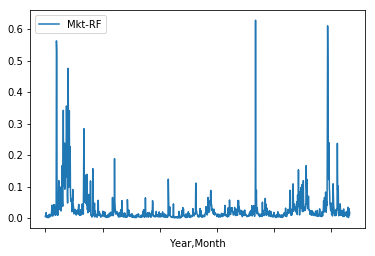

In [8]:
# construct monthly variance series using daily data
AggM=DData.groupby(['Year','Month'])
Variance=pd.DataFrame(AggM['Mkt-RF'].var()*252)
Variance.plot()

Mkt-RF    0.078458
RF        0.033940
dtype: float64

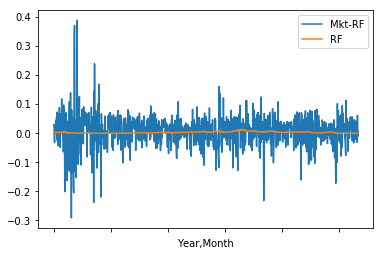

In [9]:
#monthly return series
AggM2=MData.groupby(['Year','Month'])
Ret=pd.DataFrame(AggM2[['Mkt-RF','RF']].mean())
Ret.plot()
Ret.mean()*12

In [10]:
#merge together
Data=Ret.join(Variance,rsuffix='v')
Data.columns=['MKTRF','RF','RealizedVariance']
Data.head()

MKTRF      RF  RealizedVariance
Year Month                                  
1926 7      0.0296  0.0022          0.005166
     8      0.0264  0.0025          0.008850
     9      0.0036  0.0023          0.006190
     10    -0.0324  0.0032          0.017734
     11     0.0253  0.0031          0.003676

In [11]:
# lag realized variance to make it known at the time of portfolio formation
Data['RealizedVariance']=Data['RealizedVariance'].shift(1)

In [12]:
# construct vvolatility managed portfolio
StdYear=0.18
VarMonth=StdYear**2/12

Data['VolmanagedRet']=Data['MKTRF']/Data['RealizedVariance']
# Normalize normalize it so it has the desired variance
crv=np.sqrt(VarMonth/Data['VolmanagedRet'].var())
Data['VolmanagedRet']=Data['VolmanagedRet']*crv


In [13]:
Data[['MKTRF','VolmanagedRet']].mean()*12

MKTRF            0.078458
VolmanagedRet    0.092665
dtype: float64

In [14]:
Data[['MKTRF','VolmanagedRet']].std()*12**0.5

MKTRF            0.187007
VolmanagedRet    0.180000
dtype: float64

lets look at the value of a fully invested portfolio


$$ R_{t+1}=RF_{t+1}+R^{Volmanaged}_{t+1}$$


and compare with the gains of investing in the market

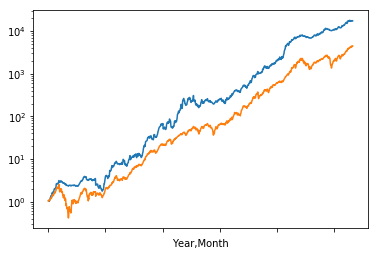

In [15]:
(Data['VolmanagedRet']+Data['RF']+1).cumprod().plot(logy=True)
(Data['MKTRF']+Data['RF']+1).cumprod().plot(logy=True)


In [16]:
#But does it generate alpha?


y=Data[['VolmanagedRet']]*12
x=Data[['MKTRF']]*12;
x=sm.add_constant(x)
results = sm.OLS(y,x,missing='drop').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          VolmanagedRet   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     627.8
Date:                Fri, 16 Nov 2018   Prob (F-statistic):          2.94e-109
Time:                        08:53:10   Log-Likelihood:                -760.47
No. Observations:                1065   AIC:                             1525.
Df Residuals:                    1063   BIC:                             1535.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0468      0.015      3.067      0.002       0.017       0.077
MKTRF          0.5863      0.023     25.057      0.000       0.540       0.632
==============================================================================
Omnibus:                      244.009   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4579.023
Skew:                           0.533   Prob(JB):                         0.00
Kurtosis:                      13.102   Cond. No.                         1.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""